This program is part of pyHNC, copyright (c) 2023 Patrick B Warren (STFC).
Additional modifications copyright (c) 2025 Joshua F Robinson (STFC).
Email: patrick.warren{at}stfc.ac.uk.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see
<http://www.gnu.org/licenses/>.

Demonstrate the capabilities of the HNC package for solving DPD
potentials, comparing with SunlightHNC if requested, and plotting
the pair distribution function and the structure factor too.  For
details here see also the SunlightHNC documentation.

For standard DPD at $A = 25$ and $ρ = 3$, we have the following table

```
          ∆t = 0.02   ∆t = 0.01   Monte-Carlo  HNC   deviation
pressure  23.73±0.02  23.69±0.02  23.65±0.02   23.564  (0.4%)
energy    13.66±0.02  13.64±0.02  13.63±0.02   13.762  (1.0%)
mu^ex     12.14±0.02  12.16±0.02  12.25±0.10   12.170  (0.7%)
```


The first two columns are from dynamic simulations.  The excess
chemical potential (final row) is measured by Widom insertion.  The
HNC results from the present code are in agreement with those from
SunlightHNC to at least the indicated number of decimals.  The
deviation is between HNC and simulation results.

Data is from a forthcoming publication on osmotic pressure in DPD.

## Standard modules

In [1]:
import os
import pyHNC
import argparse
import numpy as np, matplotlib.pyplot as plt
from numpy import pi as π
from scipy.integrate import simpson
from pyHNC import Grid, PicardHNC, TestParticleRPA, SolutePicardHNC, SoluteTestParticleRPA, truncate_to_zero

## Global parameters

In [2]:
N = 2**13
Δr = 0.02
grid = Grid(N, Δr)
r, q = grid.r, grid.q

verbose = False

alpha = 0.2
npicard = 1000
tol = 1e-12
solvent = PicardHNC(grid, alpha=alpha, npicard=npicard, tol=tol)
solvent_rpa = TestParticleRPA(grid, alpha=alpha, npicard=npicard, tol=tol)

print(grid.details + '\n' + solvent.details)

Grid: ng = 8192 = 2^13, Δr = 0.02, Δq = 0.0192, |FFTW arrays| = 8191
PicardHNC: α = 0.2, tol = 1.0e-12, npicard = 1000


# 1. Solve for pure solvent

Define interaction parameters:

In [3]:
def dpd_potential(A, r):
    """Define the DPD potential."""
    return truncate_to_zero(A/2*(1-r)**2, r, 1)

def dpd_force(A, r):
    """Define dereivative of the DPD potential."""
    return truncate_to_zero(A*(1-r), r, 1) # the force f = -dφ/dr

# Parameters for solvent-solvent interactions
A00 = 25
ρ0 = 3.0
φ0, f0 = dpd_potential(A00, r), dpd_force(A00, r)

Solve for $h(r)$ via Picard iteration with HNC closure:

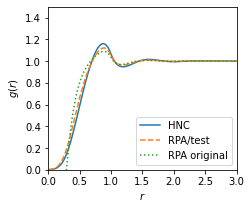

In [4]:
soln = solvent.solve(φ0, ρ0, monitor=verbose) # solve for the DPD potential
h00, c00, h00q = soln.hr, soln.cr, soln.hq # extract for use in a moment

soln2 = solvent_rpa.solve(φ0, ρ0, monitor=verbose) # solve for the DPD potential
h00_rpa, c00_rpa, h00q_rpa = soln2.hr, soln2.cr, soln2.hq # extract for use in a moment

φ0q = grid.fourier_bessel_forward(φ0)
h00q_rpa_pure = -φ0q / (1 + ρ0 * φ0q)
h00_rpa_pure = grid.fourier_bessel_backward(h00q_rpa_pure)

plt.figure(figsize=(3.375, 3))
plt.plot(r, 1+h00, label='HNC')
plt.plot(r, 1+h00_rpa, '--', label='RPA/test')
plt.plot(r, 1+h00_rpa_pure, ':', label='RPA original')
plt.legend(loc='best')
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.xlim([0, 3])
plt.ylim([0, 1.5])
plt.show()

Calculate thermodynamic quantities using the total correlation function $h(r)$.

For the integrals here, see Eqs. (2.5.20) and (2.5.22) in Hansen & McDonald, "Theory of Simple Liquids" (3rd edition): for the (excess) energy density,
$$
e \equiv \frac{U^\mathrm{ex}}{V} = 2\pi\rho^2 \int_0^\infty \mathrm{d}r \, r^2 \phi(r) g(r)
$$
and virial pressure,
$$
p = \rho + \frac{2\pi\rho^2}{3} \int_0^\infty \mathrm{d}r \, r^3 f(r) g(r)
$$
where $f(r) = −\mathrm{d}\phi/\mathrm{d}r$ is the force. Note that we have assumed $\beta = 1$ in our expressions, so energy is given in units of $k_\mathrm{B} T$. An integration by parts shows that the mean-field contributions, being these with g(r) = 1, are the same.

Here specifically the mean-field contributions are
$$
\frac{2\pi \rho^3}{3} \int_0^\infty \mathrm{d}r \, r^3 f(r) = A \int_0^1 \mathrm{d}r \, r^3 (1−r) = \frac{\pi A \rho^3}{30} \,.
$$

In [5]:
# e_mf = p_mf = π*A00*ρ0**2/30

# e_xc = 2*π*ρ0**2 * np.trapz(r**2*φ0*h00, dx=Δr)
# e_ex = e_mf + e_xc
# e = 3*ρ0/2 + e_ex

# p_xc = 2*π*ρ0**2/3 * np.trapz(r**3*f0*h00, dx=Δr)
# p_ex = p_mf + p_xc
# p = ρ0 + p_ex

Routes to chemical potential need a write up.

In [6]:
class ExcessChemicalPotential:
    """Chemical potential by different routes."""

    @classmethod
    def test_particle(cls, h, c, r):
        """Chemical potential/test particle route with HNC closure."""
        return 4*π*ρ0 * simpson(r**2*(h*(h-c)/2 - c), r)

    @classmethod
    def compressibility(cls, h, c, r):
        """Generic compressibility route."""
        return -4*π*ρ0 * simpson(r**2*c, r)

μ_ex = ExcessChemicalPotential.test_particle(h00, c00, r)
μ = np.log(ρ0) + μ_ex
print(f'  test particle: μ={μ:.4f} μ_ex={μ_ex:.4f} μ_id={μ-μ_ex:.4f}')
μ_ex = ExcessChemicalPotential.compressibility(h00, c00, r)
μ = np.log(ρ0) + μ_ex
print(f'compressibility: μ={μ:.4f} μ_ex={μ_ex:.4f} μ_id={μ-μ_ex:.4f}')

  test particle: μ=13.2689 μ_ex=12.1703 μ_id=1.0986
compressibility: μ=15.5487 μ_ex=14.4501 μ_id=1.0986


# 2. Introduce solute

We need to use a different solver that takes into account that this is now a binary mixture where the second species (the solute) is infinitely dilute. We need to pass the previously obtained static properties of the solvent.

In [7]:
solute = SolutePicardHNC(1+ρ0*h00q, grid, alpha=alpha, npicard=npicard, tol=tol)
solute_rpa = SoluteTestParticleRPA(1+ρ0*h00q_rpa, grid, alpha=alpha, npicard=npicard, tol=tol)

Show how the distribution function $g_{01}$ between solvent (species 0) and solute (species 1) varies with DPD interaction parameter $A_{01}$. We can also infer $g_{11}$ directly from $g_{01}$ and thereby calculate the potential of mean force between two solute particles:
$$
- \ln{g_{11}(r)} = \beta \phi_{11}(r) + \beta W_{11}(r)\,.
$$
Here $\beta W_{11}$ is the depletion potential between solutes.

/tmp/ipykernel_8366/2008553495.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/tmp/ipykernel_8366/2008553495.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


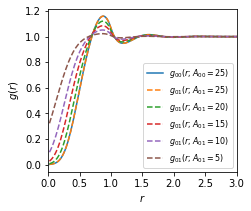

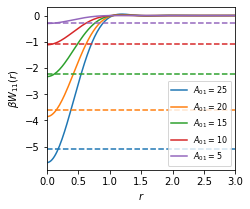

In [8]:
fig1 = plt.figure(figsize=(3.375, 3))
ax1 = plt.gca()
fig2 = plt.figure(figsize=(3.375, 3))
ax2 = plt.gca()

ax1.plot(r, 1+h00, label=(r'$g_{00}(r; A_{00}=' + f'{A00})$'))

# for A01 in np.arange(A00, 151, 25):
for A01 in np.flipud(np.arange(5, 26, 5)):
    φ01 = dpd_potential(A01, r)
    soln = solute.solve(φ01, monitor=verbose)
    h01, c01, h01q = soln.hr, soln.cr, soln.hq
    ax1.plot(r, 1+h01, '--', label=(r'$g_{01}(r; A_{01}=' + f'{A01})$'))

    c01q = grid.fourier_bessel_forward(c01)
    depletion11 = - ρ0 * grid.fourier_bessel_backward(c01q * h01q)
    pl, = ax2.plot(r, depletion11, label=(r'$A_{01}=' + f'{A01}$'))

    # Equivalent calculation should be on top of other lines.
    # psi1q = h01q / (1 + ρ0*h00q)**0.5
    # depletion11 = - ρ0 * grid.fourier_bessel_backward(psi1q**2)
    # ax2.plot(r, depletion11, '--', c=pl.get_color())

    # Work out the expected value at g(r=0) if the theory were self-consistent.
    φ01_eff = dpd_potential(2*A01, r)
    soln_eff = solute.solve(φ01_eff, monitor=verbose)
    h01_eff, c01_eff, h01q_eff = soln_eff.hr, soln_eff.cr, soln_eff.hq
    μ_ex_monomer = ExcessChemicalPotential.test_particle(h01, c01, r)
    μ_ex_eff = ExcessChemicalPotential.test_particle(h01_eff, c01_eff, r)
    dμ = μ_ex_eff - 2*μ_ex_monomer
    ax2.axhline(y=dμ, ls='--', c=pl.get_color())

for ax in [ax1, ax2]:
    ax.legend(loc='best', fontsize=8)
    ax.set_xlabel('$r$')
    ax.set_xlim([0, 3])

ax1.set_ylabel('$g(r)$')
ax2.set_ylabel(r'$\beta W_{11}(r)$')

fig1.show()
fig2.show()

Calculate excess chemical potentials for solutes with varying solvent-solute interaction parameters $A_{01}$:

In [9]:
A01 = np.flipud(np.arange(0, 151, 1))
μ_ex_hnc_test = np.empty(len(A01))
μ_ex_hnc_comp = np.empty(len(A01))

for i, A in enumerate(A01[:-1]):
    φ01 = dpd_potential(A, r)
    soln = solute.solve(φ01, monitor=verbose)
    h01, c01, h01q = soln.hr, soln.cr, soln.hq
    μ_ex_hnc_test[i] = ExcessChemicalPotential.test_particle(h01, c01, r)
    μ_ex_hnc_comp[i] = ExcessChemicalPotential.compressibility(h01, c01, r)

μ_ex_hnc_test[-1] = 0.
μ_ex_hnc_comp[-1] = 0.

In [10]:
μ_ex_rpa_test = np.empty(len(A01))
μ_ex_rpa_comp = np.empty(len(A01))

for i, A in enumerate(A01[:-1]):
    φ01 = dpd_potential(A, r)
    soln = solute_rpa.solve(φ01, monitor=verbose)
    h01, c01, h01q = soln.hr, soln.cr, soln.hq
    μ_ex_rpa_test[i] = ExcessChemicalPotential.test_particle(h01, c01, r)
    μ_ex_rpa_comp[i] = ExcessChemicalPotential.compressibility(h01, c01, r)

μ_ex_rpa_test[-1] = 0.
μ_ex_rpa_comp[-1] = 0.

Plot the previously calculated chemical potentials:
digitised from Fig 1 of Hendrikse *et al.*, PCCP **27**, 1554-66 (2025).


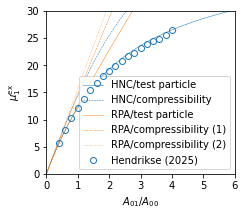

In [11]:
plt.figure(figsize=(3.375, 3))
pl, = plt.plot(A01/A00, μ_ex_hnc_test, '-', lw=0.5, label='HNC/test particle')
plt.plot(A01/A00, μ_ex_hnc_comp, '--', lw=0.5, c=pl.get_color(), label='HNC/compressibility')

pl2, = plt.plot(A01/A00, μ_ex_rpa_test, '-', lw=0.5, label='RPA/test particle')
plt.plot(A01/A00, μ_ex_rpa_comp, '--', lw=0.5, c=pl2.get_color(), label='RPA/compressibility (1)')
μ_rpa = ρ0 * np.pi * A01 / 15
plt.plot(A01/A00, μ_rpa, ':', lw=0.5, c=pl2.get_color(), label='RPA/compressibility (2)')

A01_ref, μ_ex_ref = np.genfromtxt('hendrikse2025_mu_dpd.csv', delimiter=',', comments='#').T
plt.plot(A01_ref/A00, μ_ex_ref, 'o', c=pl.get_color(),
         mfc='None', label='Hendrikse (2025)', zorder=10)

plt.xlabel(r'$A_{01} / A_{00}$')
plt.ylabel(r'$\mu_1^\mathrm{ex}$')
plt.legend(loc='best')
plt.xlim([0, np.max(A01)/A00])
plt.ylim([0, 30])

plt.show()

# 3. Partition coefficients of dimers

Taking the depletion potential from the previous section we can integrate over all configurations of a dimer to obtain its chemical potential:

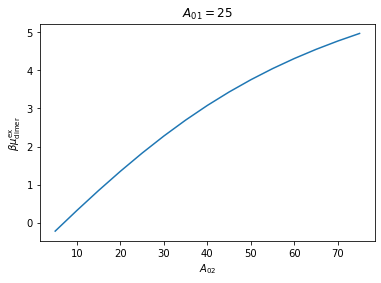

In [13]:
def bond_potential(r, l0=0.5, k=150):
    """Spring force between bonded atoms in a molecule."""
    return k * (r - l0)**2

from scipy.integrate import simpson

def dimer_excess_chemical_potential(A1, A2, l0=0.5, k=150):
    """Excess chemical potential of a non-rigid dimer is found by integrating
    the potential of mean force over all configurations of the two beads.

    Args:
        A1: interaction strength of bead 1 with the solvent.
        A2: interaction strength of bead 2 with the solvent.
        l0: equilbrium length of dimer in a vacuum.
        k: interaction strength between the two beads (a spring constant).
    Returns:
        Excess chemical potential in units of kT.
    """
    φ01, φ02 = [dpd_potential(A, r) for A in [A1, A2]]
    soln = solute.solve(φ01, monitor=verbose)
    h01, c01, h01q = soln.hr, soln.cr, soln.hq
    soln = solute.solve(φ02, monitor=verbose)
    h02, c02, h02q = soln.hr, soln.cr, soln.hq

    # Depletion contribution to potential of mean force
    psi1q, psi2q = [hq / (1 + ρ0*h00q)**0.5 for hq in [h01q, h02q]]
    depletion12 = - ρ0 * grid.fourier_bessel_backward(psi1q*psi2q)

    v12 = bond_potential(r, l0, k)
    φ12 = v12 + depletion12
    return np.log(simpson(4*np.pi * r**2 * np.exp(-φ12), r))

A1 = 25
A2 = np.arange(5, 76, 5)
μ_ex_dimer = [dimer_excess_chemical_potential(A1, A) for A in A2]
plt.plot(A2, μ_ex_dimer)
plt.xlabel('$A_{02}$')
plt.ylabel(r'$\beta \mu_\mathrm{dimer}^\mathrm{ex}$')
plt.title(r'$A_{01} = 25$')
plt.show()


The partition coefficient is obtained from the ratio of excess chemical potentials in two solvents $\alpha$ and $\beta$:
$$
\ln{K_{ij}^{\alpha\beta}}
\equiv
\ln{\left( \frac{c_{ij}^\alpha}{c_{ij}^\beta} \right)}
=
\beta \mu_{ij,\alpha}^\text{ex} - \beta \mu_{ij,\beta}^\text{ex}\,.
$$

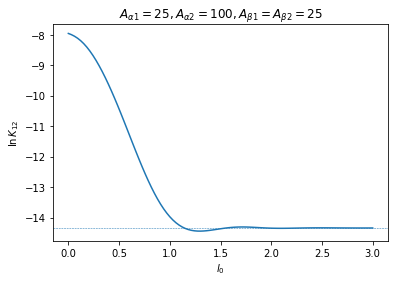

In [14]:
def monomer_partition_coefficient(Aα1, Aβ1):
    """Partition coefficient of a monomer for two reference solvents.
    Args:
        Aα1: interaction coefficient between solute and first solvent.
        Aβ1: interaction coefficient between solute and second solvent.
    Returns:
        Difference between excess chemical potentials in units of kT.
    """
    φα1, φβ1 = [dpd_potential(A, r) for A in [Aα1, Aβ1]]

    soln = solute.solve(φα1, monitor=verbose)
    hα1, cα1, hα1q = soln.hr, soln.cr, soln.hq
    μ_ex_α = ExcessChemicalPotential.test_particle(hα1, cα1, r)

    soln = solute.solve(φβ1, monitor=verbose)
    hβ1, cβ1, hβ1q = soln.hr, soln.cr, soln.hq
    μ_ex_β = ExcessChemicalPotential.test_particle(hβ1, cβ1, r)

    return μ_ex_β - μ_ex_α

def dimer_partition_coefficient(A1, A2, l0=0.5, k=150):
    """Partition coefficient of a dimer for two reference solvents.
    Args:
        A1: interaction coefficients of first bead with each solvent.
        A2: interaction coefficients of second bead with each solvent.
        l0: equilbrium length of dimer in a vacuum.
        k: interaction strength between the two beads (a spring constant).
    Returns:
        Difference between excess chemical potentials in units of kT.
    """

    K1 = monomer_partition_coefficient(*A1)
    K2 = monomer_partition_coefficient(*A2)

    Aα1, Aβ1 = A1
    Aα2, Aβ2 = A2
    μ_ex_α = dimer_excess_chemical_potential(Aα1, Aα2, l0, k)
    μ_ex_β = dimer_excess_chemical_potential(Aβ1, Aβ2, l0, k)

    return K1 + K2 + μ_ex_α - μ_ex_β

A1 = [25, 25]
A2 = [100, 25]
K1 = monomer_partition_coefficient(*A1)
K2 = monomer_partition_coefficient(*A2)

l0 = np.linspace(0, 3, 100)
logP = [dimer_partition_coefficient(A1, A2, ll) for ll in l0]

plt.plot(l0, logP)
plt.axhline(y=(K1+K2), ls='--', lw=0.5)
plt.xlabel('$l_0$')
plt.ylabel(r'$\ln{K_{12}}$')
plt.title(r'$A_{\alpha 1} = 25, A_{\alpha 2} = 100, A_{\beta 1} = A_{\beta 2} = 25$')
plt.show()